### Abstract

The goals of this experiment is to examine thresholding on a dataset focussing on loan defaulting and how that can be down to maximize the gain of a bank when deciding to make loans using a machine learning model. To complete this experiment plots were initially made to find possible features of the dataset to conduct model training on. Once features were found, a logistic regression model was trained and its model weights were used to conduct experimenting to find the ideal threshold for bank gain maximization. The weight was used to calculate a linear score which produced scores which aided in thresholding. An ROC curve was created to visualize the effectiveness of the model, and then the gain was calculated using the TNR and the FNR. Through this the gain was found to be about 8million with a weight of [-0.05043871,  0.27511746] and a threshold of 5.8.

In [6]:
import pandas as pd
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df_all = pd.read_csv(url)

In [7]:
df_all

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,25,43200,RENT,NaN,VENTURE,B,1200,9.91,0,0.03,N,4
1,27,98000,RENT,3.0,EDUCATION,C,11750,13.47,0,0.12,Y,6
2,22,36996,RENT,5.0,EDUCATION,A,10000,7.51,0,0.27,N,4
3,24,26000,RENT,2.0,MEDICAL,C,1325,12.87,1,0.05,N,4
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,A,15000,9.63,0,0.28,N,10
...,...,...,...,...,...,...,...,...,...,...,...,...
26059,36,150000,MORTGAGE,8.0,EDUCATION,A,3000,7.29,0,0.02,N,17
26060,23,48000,RENT,1.0,VENTURE,A,4325,5.42,0,0.09,N,4
26061,22,60000,RENT,0.0,MEDICAL,B,15000,11.71,0,0.25,N,4
26062,30,144000,MORTGAGE,12.0,PERSONAL,C,35000,12.68,0,0.24,N,8


In [8]:
df_all.groupby(['loan_intent']).aggregate({'person_age':'mean', 'person_emp_length':'mean'})

,person_age,person_emp_length
loan_intent,,
DEBTCONSOLIDATION,27.588798,4.759419
EDUCATION,26.597620,4.440192
HOMEIMPROVEMENT,28.981737,5.103754
MEDICAL,27.950982,4.782062
PERSONAL,28.288339,4.897997
VENTURE,27.588643,4.877869


Looking at the above dataframe we can see there isn't really a stark correlation between loan intent, age, and employment length. I think the only conclusion that could be drawn from this is that mean employment length can slightly be determined but even that is a stretch

### Feature Exploration

The following code aims to explore possible classification features in the dataset used in this experiment

<Axes: xlabel='loan_int_rate', ylabel='loan_percent_income'>

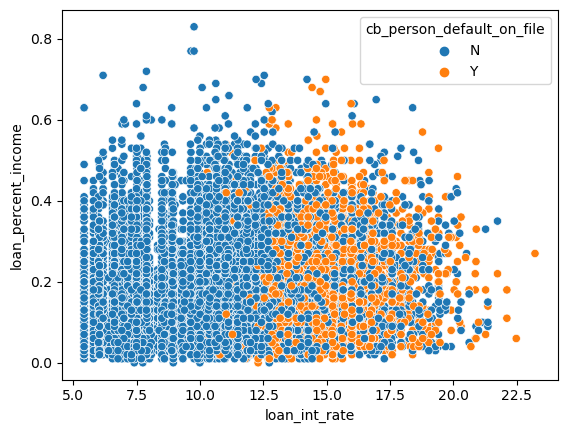

In [9]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.scatterplot(data=df_all[['loan_percent_income', 'loan_int_rate', 'cb_person_default_on_file']], x='loan_int_rate', y='loan_percent_income', hue='cb_person_default_on_file')

In the above plot we can see that as there is a relationship between loan interest rate, loan percent income, and someone's likelihood to have defaulted on a loan. It seems that loan interest rate is the larger factor seeing as regardless of loan percent income, there is an abrupt increase in load defaults as loan interest rate reaches a level of 12.5 or above.

(0.0, 250000.0)

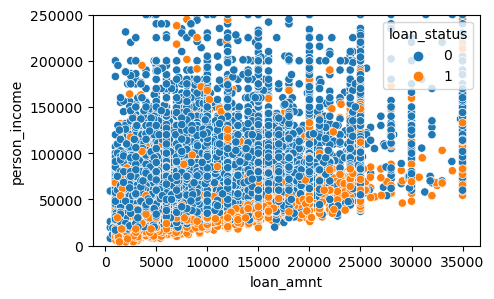

In [10]:
fig, axs = plt.subplots(1, 1, figsize=(5,3))

sns.scatterplot(ax=axs, data=df_all[['person_income', 'loan_amnt', 'loan_status']], x='loan_amnt', y='person_income', hue='loan_status')
axs.set_ylim(0,250000)

Looking at the above graph there seems to be a slight trend that there is a relationship between loan amount, person income, and whether or not someone has defaulted on their loan. There is a heavey concentration of loan defaults for persons with an income of $50,000 or lower and this trend maintains for loans less than $5000 and up to loans of $35000.

In [11]:
df_all["gain_if_repaid"] = df_all['loan_amnt']*(1 + df_all['loan_int_rate']/100)**10 - df_all['loan_amnt']
df_all["cost_if_default"] = df_all['loan_amnt']*(1 + df_all['loan_int_rate']/100)**5 - 1.5*df_all['loan_amnt']
df_all

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,gain_if_repaid,cost_if_default
0,25,43200,RENT,NaN,VENTURE,B,1200,9.91,0,0.03,N,4,1887.118673,124.718787
1,27,98000,RENT,3.0,EDUCATION,C,11750,13.47,0,0.12,Y,6,29826.546771,4477.588639
2,22,36996,RENT,5.0,EDUCATION,A,10000,7.51,0,0.27,N,4,10629.496036,-637.028150
3,24,26000,RENT,2.0,MEDICAL,C,1325,12.87,1,0.05,N,4,3121.324231,439.716432
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,A,15000,9.63,0,0.28,N,10,22617.107668,1254.086280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26059,36,150000,MORTGAGE,8.0,EDUCATION,A,3000,7.29,0,0.02,N,17,3063.364932,-235.015264
26060,23,48000,RENT,1.0,VENTURE,A,4325,5.42,0,0.09,N,4,3006.894895,-856.297160
26061,22,60000,RENT,0.0,MEDICAL,B,15000,11.71,0,0.25,N,4,30395.392679,3594.652521
26062,30,144000,MORTGAGE,12.0,PERSONAL,C,35000,12.68,0,0.24,N,8,80487.884885,11077.322773


The above code is calculating `gain if repaid` and `cost if default` based on an interest rate calculation supplied by Professor Chodrow. Those values will be used later on in the experiment we we look into thresholding and how our model predictions will go into loss and gain calculations.

In [12]:
cols = ['person_emp_length', 'loan_int_rate', 'loan_status', 'gain_if_repaid', 'cost_if_default']
df = df_all[cols]
df = df.dropna()
df

,person_emp_length,loan_int_rate,loan_status,gain_if_repaid,cost_if_default
1,3.0,13.47,0,29826.546771,4477.588639
2,5.0,7.51,0,10629.496036,-637.028150
3,2.0,12.87,1,3121.324231,439.716432
4,2.0,9.63,0,22617.107668,1254.086280
6,2.0,14.91,1,16577.044649,2769.244329
...,...,...,...,...,...
26059,8.0,7.29,0,3063.364932,-235.015264
26060,1.0,5.42,0,3006.894895,-856.297160
26061,0.0,11.71,0,30395.392679,3594.652521
26062,12.0,12.68,0,80487.884885,11077.322773


For our experiment we are going to be looking into how person employment length and loan interest rate can be used to predict loan status

In [13]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size = 0.2)

In [14]:
X_train = df_train[["person_emp_length", "loan_int_rate"]]
y_train = df_train["loan_status"]

X_test = df_test[["person_emp_length", "loan_int_rate"]]
y_test = df_test["loan_status"]

Here we are splitting the data into training and testing data and then further splitting it into a training list of just `features` and a list of `targets`, those being `X_train` and `y_train` respectively.

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
LR = LogisticRegression()

m = LR.fit(X_train, y_train)
LR.score(X_train, y_train)


0.8018008185538882

In [16]:
from sklearn.model_selection import cross_val_score
cv_scores_LR = cross_val_score(LR, X_train, y_train, cv = 5)
cv_scores_LR.mean()

0.8019645293315143

We now train a Logistic Regression model using our training data and conduct a cross validation on that. We get a training score and a cross validation score of ~80 which isn't great, but it is good enough to continue with our experiment

In [17]:
import numpy as np
from matplotlib import pyplot as plt
w = LR.coef_[0]
w


array([-0.04834875,  0.27540715])

We trained a logistic regression model above in order to get a weight value from the model using the above code `LR.coef_[0]`. This is done so we can use the weight along with our `X_train` data to create scores for our target values.

### Score Calculation

Can divide scores by t to put them between 0-1

In [18]:
def linear_score(X, w):
    return X@w

In [19]:
s = linear_score(X_train, w)
df['score'] = s
df.dropna()
df

,person_emp_length,loan_int_rate,loan_status,gain_if_repaid,cost_if_default,score
1,3.0,13.47,0,29826.546771,4477.588639,3.564688
2,5.0,7.51,0,10629.496036,-637.028150,1.826564
3,2.0,12.87,1,3121.324231,439.716432,3.447793
4,2.0,9.63,0,22617.107668,1254.086280,2.555473
6,2.0,14.91,1,16577.044649,2769.244329,4.009623
...,...,...,...,...,...,...
26059,8.0,7.29,0,3063.364932,-235.015264,1.620928
26060,1.0,5.42,0,3006.894895,-856.297160,1.444358
26061,0.0,11.71,0,30395.392679,3594.652521,3.225018
26062,12.0,12.68,0,80487.884885,11077.322773,2.911978


Using the `linear_score()` function we created above we can create a list of scores and append that to our dataframe with both our `cost if default` and `gain if repaid` information as well.

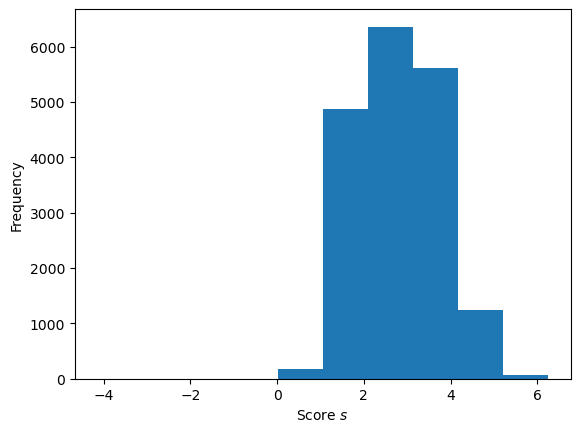

In [20]:
hist = plt.hist(s)
labs = plt.gca().set(xlabel = r"Score $s$", ylabel = "Frequency") 

We can plot a histogram of our scores to see where we might want to look for our threshold. We are trying to find a threshold that maximizes our prediction accuracy and that process can be seen in the code block below.

### Thresholding

In [21]:
for t in np.linspace(0, 6, 11):
    y_pred = s>= t
    acc    = (y_pred == y_train).mean()
    print(f"A threshold of {t:.1f} gives an accuracy of {acc:.2f}.")

A threshold of 0.0 gives an accuracy of 0.22.
A threshold of 0.6 gives an accuracy of 0.22.
A threshold of 1.2 gives an accuracy of 0.23.
A threshold of 1.8 gives an accuracy of 0.36.
A threshold of 2.4 gives an accuracy of 0.50.
A threshold of 3.0 gives an accuracy of 0.65.
A threshold of 3.6 gives an accuracy of 0.78.
A threshold of 4.2 gives an accuracy of 0.81.
A threshold of 4.8 gives an accuracy of 0.79.
A threshold of 5.4 gives an accuracy of 0.79.
A threshold of 6.0 gives an accuracy of 0.78.


In [22]:
t = 4.2
y_pred = s>= t
((y_train == 0) * (y_pred == 1)).sum() # calculating false positives
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_pred)
confusion_matrix(y_train, y_pred, normalize="true")

array([[0.97099534, 0.02900466],
       [0.79533941, 0.20466059]])

From looping through possible score thresholds we found that 4.2 gave an accuracy of 0.81 which is the highest we saw in our possible thresholds. We will get a more exact value later on but here we can use it to confirm our progress so far by creating a confusion matrix to see true positives, true negatives, false positives, and false negatives.

In [23]:
df['preds'] = y_pred
df['preds'].sum()

1225

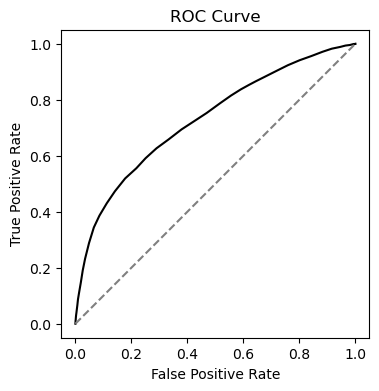

In [24]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))

num_thresholds = 101

FPR = np.zeros(num_thresholds)
TPR = np.zeros(num_thresholds)
T = np.linspace(s.min()-0.1, s.max()+0.1, num_thresholds)
s    = linear_score(X_train, w)

for i in range(num_thresholds):
    t = T[i]
    preds    = s >= t
    FPR[i]   = ((preds == 1) & (y_train == 0)).sum() / (y_train == 0).sum()
    TPR[i]   = ((preds == 1) & (y_train == 1)).sum() / (y_train == 1).sum()

ax.plot(FPR, TPR, color = "black")
ax.plot([0,1], [0,1], linestyle="--", color = "grey")
ax.set_aspect('equal')

labs = ax.set(xlabel = "False Positive Rate", ylabel = "True Positive Rate", title = "ROC Curve")

Above we are creating a plot of the TPR v FPR and how that changes as we use different threshold values.

### Gain Calculation

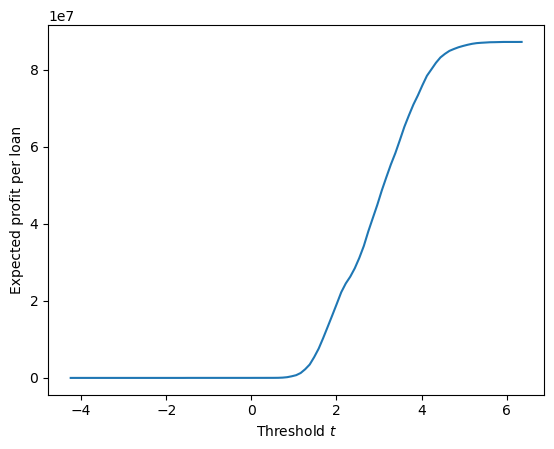

In [25]:
TNR = 1 - FPR
FNR = 1 - TPR

cost_of_FN = df.loc[df["preds"] == False]['cost_if_default'].sum()
gain_of_TN = df.loc[df["preds"] == True]['gain_if_repaid'].sum()

gain =  cost_of_FN*FNR  + gain_of_TN*TNR

plt.plot(T, gain)
#plt.gca().set(ylim = (), xlim = ())
labs = plt.gca().set(xlabel = r"Threshold $t$", ylabel = "Expected profit per loan")

Here we are plotting the gain of our model using different threshold values. We can see that a threshold of around 4.5 is when our model starts to plateau and we don't see any more increase to our profits. I don't think this exactly what we'd like to see. Ideally there is a distinct spike that would point out where our ideal threshold should be, but I think the important piece here is that we see a trend similar to what we saw earlier in the experiment that thresholds less than 4 are not ideal.

In [26]:
t = 5.8

# compute the scores
s     = linear_score(X_test, w)
preds = s >= t

# compute error rates
FPR   = ((preds == 1) & (y_test == 0)).sum() / (y_test == 0).sum()
TPR   = ((preds == 1) & (y_test == 1)).sum() / (y_test == 1).sum()

TNR = 1 - FPR
FNR = 1 - TPR

# compute the expected gain
gain = cost_of_FN*FNR  + gain_of_TN*TNR 
gain

87232429.77910945

Here we are calculating our max possible gain, which as we can see uses a threshold larger than what was first thought from the plot above, but through this calculation we can see that the max gain we can get from a threshold of 5.8 is ~ $8.7 million which feels quite high, but is the calculation we are getting.

### Gain Calculation on Test Dataset

For the following data we are going to follow a very similar process to that of what was accomplished above. We are going to use our previously calculated weight, compute scores for the dataset, gain and cost values, then calculate a total gain, and a gain per loan for the dataset.

In [27]:
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/test.csv"
df_test = pd.read_csv(url)

In [28]:
df_test

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,21,42000,RENT,5.0,VENTURE,D,1000,15.58,1,0.02,N,4
1,32,51000,MORTGAGE,2.0,DEBTCONSOLIDATION,B,15000,11.36,0,0.29,N,9
2,35,54084,RENT,2.0,DEBTCONSOLIDATION,C,3000,12.61,0,0.06,N,6
3,28,66300,MORTGAGE,11.0,MEDICAL,D,12000,14.11,1,0.15,N,6
4,22,70550,RENT,0.0,MEDICAL,E,7000,15.88,1,0.08,N,3
...,...,...,...,...,...,...,...,...,...,...,...,...
6512,26,26000,MORTGAGE,4.0,HOMEIMPROVEMENT,B,12000,NaN,0,0.46,N,3
6513,27,44640,RENT,0.0,MEDICAL,B,12800,11.83,0,0.29,N,9
6514,24,48000,OWN,5.0,VENTURE,A,10400,7.37,0,0.22,N,3
6515,26,65000,MORTGAGE,6.0,EDUCATION,A,6000,9.07,0,0.09,N,3


In [29]:
df_test["gain_if_repaid"] = df_test['loan_amnt']*(1 + df_test['loan_int_rate']/100)**10 - df_test['loan_amnt']
df_test["cost_if_default"] = df_test['loan_amnt']*(1 + df_test['loan_int_rate']/100)**5 - 1.5*df_test['loan_amnt']

Above is the `gain if repaid` and `cost if default` calculations that we saw previously

In [30]:
X_test = df_test[cols[:2]]
y_test = df_test[cols[2]]
X_test

,person_emp_length,loan_int_rate
0,5.0,15.58
1,2.0,11.36
2,2.0,12.61
3,11.0,14.11
4,0.0,15.88
...,...,...
6512,4.0,NaN
6513,0.0,11.83
6514,5.0,7.37
6515,6.0,9.07


In [31]:
s = linear_score(X_test, w)
df_test['score'] = s

In [32]:
t = 2.9

# compute the scores
s     = linear_score(X_test, w)
preds = s >= t
df_test["preds"] = preds

# compute error rates
FPR   = ((preds == 1) & (y_test == 0)).sum() / (y_test == 0).sum()
TPR   = ((preds == 1) & (y_test == 1)).sum() / (y_test == 1).sum()

cost_of_FN = df_test.loc[df_test["preds"] == False]['cost_if_default'].sum()
gain_of_TN = df_test.loc[df_test["preds"] == True]['gain_if_repaid'].sum()

TNR = 1 - FPR
FNR = 1 - TPR

# compute the expected gain
gain = cost_of_FN*FNR  + gain_of_TN*TNR 
gain

49821552.0501864

In [33]:
gain/len(df_test)

7644.859912565045

Looking at the code above we see something very interesting that using the same weight vector and technique for gain and cost calculations we have a much larger total gain for the chosen threshold. I'm not totally sure why this is, but instead of the previous ~ $8.7 million we are now getting a total gain calculation of ~ $49.8 million which calculates out to be a gain of $7644.86 per loan which seems to me like a crazy profit per loan for the bank to receive. This leads me to believe that my calculations somewhere are incorrect, but I can't find anything just looking at my code.

### Model Prediction Bias Analysis

It does not look like there is any age group that stands above the rest in being discriminated based on age. Though it does seem like younger ages on average are more negatively affected by the test predictions.

In [34]:
df_test.groupby(['preds'])['person_age'].mean()

preds
False    27.841419
True     27.584048
Name: person_age, dtype: float64

In [39]:
total_preds = df_test['preds'].sum()
medical_preds = df_test.loc[df_test["loan_intent"] == "MEDICAL"]['preds'].sum()
medical_actual = df_test.loc[df_test["loan_intent"] == "MEDICAL"]['loan_status'].sum()
print(f'Total Number of predicted Defaults: {total_preds}')
print(f'Number of predicted defaults on medical loans: {medical_preds}')
print(f'Number of actual Medical loans that have defaulted {medical_actual}')

Total Number of predicted Defaults: 2683
Number of predicted defaults on medical loans: 519
Number of actual Medical loans that have defaulted 348


It looks like almost a quarter of the default predictions made by the model are made on the loans with Medical as their intent. However, that is actually 200 more than the actual default status of those loans.

In [37]:
df_test.groupby('preds')['person_income'].mean()

preds
False    68560.065989
True     63495.321655
Name: person_income, dtype: float64

Although the difference between the two isn't that seemingly large. The mean income for individuals predicted not to default is $6000 higher than the mean for individuals that are predicted to default on their loans. So it seems that people with higher incomes are treated better in this model.

### Discussion

Through this study we were able to see that in a test set there was bias against person income and somewhat against people intending to pay for medical expenses with a loan. Based on the model predictions people with higher incomes were predicted to default on their loans less than people with lower incomes. Something to note is that the profit per person in the test set seemed to be ~7500 which was much higher than in the training set.

Answering the question "is it fair for people to have a harder time to get access to credit even though people seeking loans for medical purposes default on their loans statistically more than others". I don't think it's fair that they should have a harder time getting credit for their medical expenses. I believe that fairness is that everyone should have an equal opportunity to do anything, and especially for medical expenses I think people should be able to pay for and get any operation done they need to. Hence why I don't think it's fair that people should have less opportunity to get credit even if they're trying to pay for medial expenses.